<a href="https://colab.research.google.com/github/PeterLiuLiuLiu/Email-spam-detection-naive-bayes-from-scratch-/blob/main/SMS_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open_by_key("1mNTz172rgx_EXTHMxp6O39giPSWfIeXYIWhOy-eV1xc").sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

In [ ]:
df = pd.DataFrame.from_records(rows)
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df.head()

,v1,v2,,,
1,ham,"Go until jurong point, crazy.. Available only ...",,,
2,ham,Ok lar... Joking wif u oni...,,,
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
4,ham,U dun say so early hor... U c already then say...,,,
5,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 1 to 5572
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
 2           5572 non-null   object
 3           5572 non-null   object
 4           5572 non-null   object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# drop unnecessary columns
cols = [2, 3, 4]
df.drop(df.columns[cols], axis=1, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 1 to 5572
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
def label_num(row):
  if row["v1"] == "ham":
    return 0
  else:
    return 1

In [ ]:
df["label_num"]=df.apply(lambda row: label_num(row), axis=1)
df.head()

,v1,v2,label_num
1,ham,"Go until jurong point, crazy.. Available only ...",0
2,ham,Ok lar... Joking wif u oni...,0
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
4,ham,U dun say so early hor... U c already then say...,0
5,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df = df.rename(columns={"v1":"label", "v2":"text"})

In [ ]:
df.head()


,label,text,label_num
1,ham,"Go until jurong point, crazy.. Available only ...",0
2,ham,Ok lar... Joking wif u oni...,0
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
4,ham,U dun say so early hor... U c already then say...,0
5,ham,"Nah I don't think he goes to usf, he lives aro...",0


# EDA

### Check missing  values

In [ ]:
df.isnull().sum()

0
label        0
text         0
label_num    0
dtype: int64

### Check duplicates and remove them

In [ ]:
df.duplicated().sum()

409

In [ ]:
# drop duplicates
df = df.drop_duplicates(keep = 'first')

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5163 entries, 1 to 5572
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5163 non-null   object
 1   text       5163 non-null   object
 2   label_num  5163 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 161.3+ KB


In [ ]:
df.label.value_counts()

ham     4516
spam     647
Name: label, dtype: int64

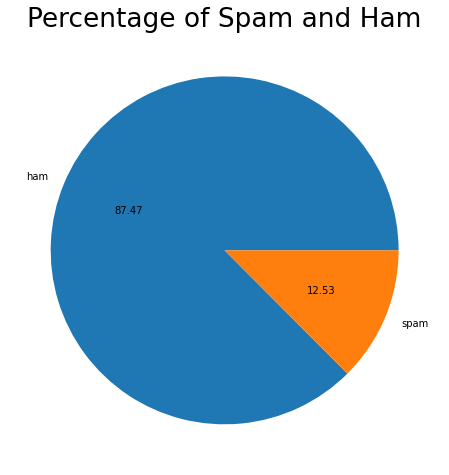

In [ ]:
plt.figure(figsize = (10, 8))
plt.pie(df['label'].value_counts(), labels=['ham','spam'], autopct="%0.2f")
plt.rcParams.update({'font.size': 22})
plt.title("Percentage of Spam and Ham")
plt.show()

# Data preprocessing

In [ ]:
# define a function to remove and punctuations
def preprocessing(text):
  nonpunc = [char for char in text if char not in string.punctuation]
  nonpunc = ''.join(nonpunc)
  return ' '.join([word for word in nonpunc.split()])


In [ ]:
df["cleaned_text"] = df.text.apply(preprocessing)

In [ ]:
df["cleaned_text"] = df["cleaned_text"].str.lower()

In [ ]:
df.head()

,label,text,label_num,cleaned_text
1,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...
2,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...
4,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say
5,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...


# Shuffle and divide train test data

In [ ]:
regex_to_parse = r"[a-zA-Z]+"
train_test_split = 0.6

In [ ]:
shuffled_df = shuffle(df)
split = int(len(df) * train_test_split)

train_df = shuffled_df.iloc[ : split, ]
test_df = shuffled_df.iloc[split : , ]
print(f"trainning data: {split} vs testing data: {len(shuffled_df) - split}")

trainning data: 3097 vs testing data: 2066


In [ ]:
train_df.head()

,label,text,label_num,cleaned_text
784,spam,You have an important customer service announc...,1,you have an important customer service announc...
4277,ham,I'm glad. You are following your dreams.,0,im glad you are following your dreams
274,ham,"Usf I guess, might as well take 1 car",0,usf i guess might as well take 1 car
2451,ham,K..give back my thanks.,0,kgive back my thanks
3850,ham,I to am looking forward to all the sex cuddlin...,0,i to am looking forward to all the sex cuddlin...


#Trainning.... Bag-of-word approach counting spam and ham sms's occurence

In [ ]:
train_df_email_per_row_ham = train_df.loc[train_df["label_num"] == 0]["cleaned_text"].str.findall(regex_to_parse).str.join(" ")
train_df_ham_word_count =  pd.Series(train_df_email_per_row_ham.str.cat(sep = " ").split(" ")).value_counts()

In [ ]:
train_df_ham_word_count

i           1228
you         1037
to           840
the          648
a            595
            ... 
kano           1
oil            1
wn             1
describe       1
pounds         1
Length: 5335, dtype: int64

In [ ]:
train_df_email_per_row_spam = train_df.loc[train_df["label_num"] == 1]["cleaned_text"].str.findall(regex_to_parse).str.join(" ")
train_df_spam_word_count =  pd.Series(train_df_email_per_row_spam.str.cat(sep = " ").split(" ")).value_counts()

In [ ]:
train_df_spam_word_count

to         386
a          212
call       190
your       152
you        147
          ... 
btooth       1
sun          1
cro          1
chatter      1
sprwm        1
Length: 1710, dtype: int64

# Base case probability without naive bayes tunning

In [ ]:
base_case_probability_of_ham = len(train_df_email_per_row_ham) / split
base_case_probability_of_spam = len(train_df_email_per_row_spam) / split

print(f"Base case P(ham) = {base_case_probability_of_ham}")
print(f"Base case P(spam) = {base_case_probability_of_spam}")

Base case P(ham) = 0.8714885372941557
Base case P(spam) = 0.12851146270584438


# Trainning.... Get term frequency log and filling the final trainning data

In [ ]:
trainning_df = pd.concat([train_df_ham_word_count, train_df_spam_word_count], axis=1).fillna(0) + 1
trainned_df = np.log(trainning_df / np.sum(trainning_df))
trainned_df.columns = ["ham", "spam"]

In [ ]:
trainned_df.head()

,ham,spam
i,-3.565364,-6.208992
you,-3.734269,-4.612977
to,-3.944728,-3.651765
the,-4.203887,-4.900660
a,-4.289079,-4.248898


In [ ]:
len(trainned_df)

6284

# Testing.... Divide the testing data into ham and spam

In [ ]:
test_df_email_per_row_ham = test_df.loc[test_df["label_num"] == 0]["cleaned_text"].str.findall(regex_to_parse).str.join(" ")
test_df_email_per_row_spam = test_df.loc[test_df["label_num"] == 1]["cleaned_text"].str.findall(regex_to_parse).str.join(" ")

## Testing.... try to predict 1 ham SMS

In [ ]:
# checking if ham is detected
test_df_ind_row_ham = pd.Series(test_df_email_per_row_ham.iloc[0, ].split(" ")).value_counts()
# merge with trainned model data for words that exists in both train and test email
test_df_ind_row_ham = trainned_df.join(test_df_ind_row_ham.rename("test").to_frame(), how = "inner")

In [ ]:
test_df_email_per_row_ham.iloc[0, ]

'everybody had fun this evening miss you'

In [ ]:
test_df_ind_row_ham

,ham,spam,test
you,-3.734269,-4.612977,1
this,-5.781480,-5.602857,1
had,-6.767297,-7.412965,1
miss,-6.990441,-8.223895,1
fun,-7.906731,-8.223895,1
evening,-8.281425,-9.610190,1


In [ ]:
result_df_ind_ham = pd.DataFrame()
# Since we taken the log of probability, the (p1 ^ occurence) * (p2 ^ occurence) * .... when logged is (occurence * p1) + (occurence * p2) + P(H) OR P(S)
result_df_ind_ham["ham_prob"]  = test_df_ind_row_ham["ham"] * test_df_ind_row_ham["test"] + base_case_probability_of_ham / len(test_df_ind_row_ham)
result_df_ind_ham["spam_prob"] = test_df_ind_row_ham["spam"] * test_df_ind_row_ham["test"] + base_case_probability_of_spam / len(test_df_ind_row_ham)

# 0th index threshold for non_spam, 1st threshold for spam
result_list_ind_ham = np.sum(result_df_ind_ham).to_list()

In [ ]:
np.sum(result_df_ind_ham)

ham_prob    -38.590155
spam_prob   -43.558268
dtype: float64

In [ ]:
print(f"The SMS '{test_df_email_per_row_ham.iloc[0, ]}' is a ham,")
if result_list_ind_ham[0] > result_list_ind_ham[1]:
    print("predicted ham")

else:
    print("predicted spam")

The SMS 'everybody had fun this evening miss you' is a ham,
predicted ham


## Testing.... try to predict 1 spam SMS

In [ ]:
# checking if ham is detected
test_df_ind_row_spam = pd.Series(test_df_email_per_row_spam.iloc[0, ].split(" ")).value_counts()
# merge with trainned model data for words that exists in both train and test email
test_df_ind_row_spam = trainned_df.join(test_df_ind_row_spam.rename("test").to_frame(), how = "inner")

In [ ]:
test_df_email_per_row_spam.iloc[0, ]

'you have new message call'

In [ ]:
test_df_ind_row_spam

,ham,spam,test
you,-3.734269,-4.612977,1
have,-5.236902,-5.405497,1
call,-5.997189,-4.357916,1
new,-7.213584,-6.054842,1
message,-7.347116,-6.719818,1


In [ ]:
result_df_ind_spam = pd.DataFrame()
# Since we taken the log of probability, the (p1 ^ occurence) * (p2 ^ occurence) * .... when logged is (occurence * p1) + (occurence * p2) + P(H) OR P(S)
result_df_ind_spam["ham_prob"]  = test_df_ind_row_spam["ham"] * test_df_ind_row_spam["test"] + base_case_probability_of_ham / len(test_df_ind_row_spam)
result_df_ind_spam["spam_prob"]      = test_df_ind_row_spam["spam"] * test_df_ind_row_spam["test"] + base_case_probability_of_spam / len(test_df_ind_row_spam)

# 0th index threshold for non_spam, 1st threshold for spam
result_list_ind_spam = np.sum(result_df_ind_spam).to_list()

In [ ]:
np.sum(result_df_ind_spam)

ham_prob    -28.657572
spam_prob   -27.022539
dtype: float64

In [ ]:
print(f"The SMS '{test_df_email_per_row_spam.iloc[0, ]}' is a spam,")
if result_list_ind_spam[0] > result_list_ind_spam[1]:
    print("predicted ham")

else:
    print("predicted spam")

The SMS 'you have new message call' is a spam,
predicted spam


# Testing..... Working on all testing hams

In [ ]:
ham_counter = 0
for i in range(len(test_df_email_per_row_ham)):
    
    test_df_ind_row_ham = pd.Series(test_df_email_per_row_ham.iloc[i, ].split(" ")).value_counts()
    test_df_ind_row_ham = trainned_df.join(test_df_ind_row_ham.rename("test").to_frame(), how = "inner")

    result_df_ind_ham = pd.DataFrame()

    result_df_ind_ham["ham_prob"]  = test_df_ind_row_ham["ham"] * test_df_ind_row_ham["test"] + base_case_probability_of_ham / max(1, len(test_df_ind_row_ham))
    result_df_ind_ham["spam_prob"] = test_df_ind_row_ham["spam"] * test_df_ind_row_ham["test"] + base_case_probability_of_spam / max(1, len(test_df_ind_row_ham))

    result_list_ind_ham = np.sum(result_df_ind_ham).to_list()

    # print(f"The SMS '{test_df_email_per_row_ham.iloc[0, ]}' is a ham,")
    if result_list_ind_ham[0] > result_list_ind_ham[1]:
        # print("predicted ham")
        ham_counter += 1
    else:
        # print("predicted spam")
        pass

In [ ]:
print(f"{ham_counter} hams detected out of {len(test_df_email_per_row_ham)} hams")

1796 hams detected out of 1817 hams


# Testing.... Working on all testing spams

In [ ]:
spam_counter = 0
for i in range(len(test_df_email_per_row_spam)):
    
    test_df_ind_row_spam = pd.Series(test_df_email_per_row_spam.iloc[i, ].split(" ")).value_counts()
    test_df_ind_row_spam = trainned_df.join(test_df_ind_row_spam.rename("test").to_frame(), how = "inner")

    result_df_ind_spam = pd.DataFrame()
    
    result_df_ind_spam["ham_prob"]  = test_df_ind_row_spam["ham"] * test_df_ind_row_spam["test"] + base_case_probability_of_ham / max(1, len(test_df_ind_row_spam))
    result_df_ind_spam["spam_prob"] = test_df_ind_row_spam["spam"] * test_df_ind_row_spam["test"] + base_case_probability_of_spam / max(1, len(test_df_ind_row_spam))

    result_list_ind_spam = np.sum(result_df_ind_spam).to_list()

    # print(f"The SMS '{test_df_email_per_row_ham.iloc[0, ]}' is a ham,")
    if result_list_ind_spam[0] > result_list_ind_spam[1]:
        # print("predicted ham")
        pass
    else:
        spam_counter += 1
        # print("predicted spam")

In [ ]:
print(f"{spam_counter} spams detected out of {len(test_df_email_per_row_spam)} spams")

219 spams detected out of 249 spams


# Testing..... Confusion matrix for all hams and spam WITH prior base case probability

In [ ]:
def confusion_matrix(spam_detected_counter, nos_of_spam, ham_detected_counter, nos_of_ham, to_print):
    # True Positive     = is spam and can be classified as spam
    tp = spam_detected_counter / nos_of_spam

    # True Negative     = is ham and can be classified as ham
    tn = ham_detected_counter / nos_of_ham

    # False Positive    = is ham but classified as spam
    fp = 1 - tn

    # False Negative    = is spam but classified as ham
    fn = 1 - tp

    if to_print:
        print(f"True Positive: {round(tp * 100, 2)} % ---- (is spam and can be classified as spam)")
        print(f"True Negative: {round(tn * 100, 2)} % ---- (is ham and can be classified as ham)")
        print(f"False Positive: {round(fp * 100, 2)} % ---- (is ham but classified as spam)")
        print(f"False Negative: {round(fn * 100, 2)} % ---- (is spam but classified as ham)")
    else:
        return tp, tn, fp, fn

In [ ]:
confusion_matrix(spam_counter, len(test_df_email_per_row_spam), ham_counter, len(test_df_email_per_row_ham), to_print = True)

True Positive: 87.95 % ---- (is spam and can be classified as spam)
True Negative: 98.84 % ---- (is ham and can be classified as ham)
False Positive: 1.16 % ---- (is ham but classified as spam)
False Negative: 12.05 % ---- (is spam but classified as ham)


# Testing..... Confusion matrix for all hams and spam WITHOUT prior base case probability

In [ ]:
ham_counter = 0
for i in range(len(test_df_email_per_row_ham)):
    
    test_df_ind_row_ham = pd.Series(test_df_email_per_row_ham.iloc[i, ].split(" ")).value_counts()
    test_df_ind_row_ham = trainned_df.join(test_df_ind_row_ham.rename("test").to_frame(), how = "inner")

    result_df_ind_ham = pd.DataFrame()

    # the term related to P(S) and P(H) are removed at respective calculations
    result_df_ind_ham["ham_prob"]  = test_df_ind_row_ham["ham"] * test_df_ind_row_ham["test"]
    result_df_ind_ham["spam_prob"] = test_df_ind_row_ham["spam"] * test_df_ind_row_ham["test"]

    result_list_ind_ham = np.sum(result_df_ind_ham).to_list()

    # print(f"The SMS '{test_df_email_per_row_ham.iloc[0, ]}' is a ham,")
    if result_list_ind_ham[0] > result_list_ind_ham[1]:
        # print("predicted ham")
        ham_counter += 1
    else:
        # print("predicted spam")
        pass

spam_counter = 0
for i in range(len(test_df_email_per_row_spam)):
    
    test_df_ind_row_spam = pd.Series(test_df_email_per_row_spam.iloc[i, ].split(" ")).value_counts()
    test_df_ind_row_spam = trainned_df.join(test_df_ind_row_spam.rename("test").to_frame(), how = "inner")

    result_df_ind_spam = pd.DataFrame()
    
    # the term related to P(S) and P(H) are removed at respective calculations
    result_df_ind_spam["ham_prob"]  = test_df_ind_row_spam["ham"] * test_df_ind_row_spam["test"]
    result_df_ind_spam["spam_prob"] = test_df_ind_row_spam["spam"] * test_df_ind_row_spam["test"]

    result_list_ind_spam = np.sum(result_df_ind_spam).to_list()

    # print(f"The SMS '{test_df_email_per_row_ham.iloc[0, ]}' is a ham,")
    if result_list_ind_spam[0] > result_list_ind_spam[1]:
        # print("predicted ham")
        pass
    else:
        spam_counter += 1
        # print("predicted spam")

In [ ]:
print("Metrics without using prior base case probability P(S) and P(H)...")
confusion_matrix(spam_counter, len(test_df_email_per_row_spam), ham_counter, len(test_df_email_per_row_ham), to_print = True)

Metrics without using prior base case probability P(S) and P(H)...
True Positive: 90.36 % ---- (is spam and can be classified as spam)
True Negative: 97.69 % ---- (is ham and can be classified as ham)
False Positive: 2.31 % ---- (is ham but classified as spam)
False Negative: 9.64 % ---- (is spam but classified as ham)


# Word Cloud for fun

In [ ]:
from wordcloud import WordCloud

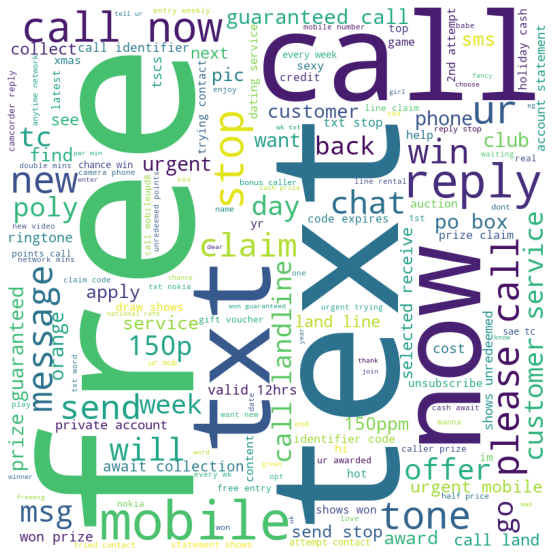

In [ ]:
wc = WordCloud(width = 800, height = 800,background_color ='white', min_font_size = 10)
spam_wc = wc.generate(df[df['label_num'] == 1]['cleaned_text'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(spam_wc)

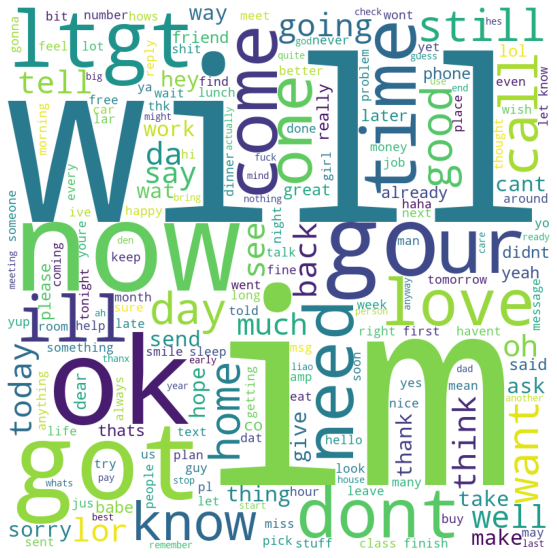

In [ ]:
wc = WordCloud(width = 800, height = 800,background_color ='white', min_font_size = 10)
ham_wc = wc.generate(df[df['label_num'] == 0]['cleaned_text'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(ham_wc)